## **Preparing Data**

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np

import random
import math
import time

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### **Tokenizers**
- We convert sentences to individual tokens by using tokenizers.
  - e.g. "good morning!" becomes ["good", "morning", "!"]
- We will use python package `spaCy` for this

In [54]:
!pip install datasets

In [55]:
from datasets import list_datasets, load_dataset
from pprint import pprint

In [56]:
dataset = load_dataset('go_emotions', split=['train', 'validation', 'test'])

In [57]:
raw_train_dataset = dataset[0].map(remove_columns=['id'])

In [58]:
raw_validation_dataset = dataset[1].map(remove_columns=['id'])

In [59]:
raw_test_dataset = dataset[2].map(remove_columns=['id'])

In [60]:
# !pip install transformers

In [61]:
# from transformers import BertTokenizerFast, logging as transformers_logging

# transformers_logging.set_verbosity_warning()

# tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')

In [62]:
import spacy

spacy_en = spacy.load('en_core_web_sm')

def tokenize_en(text):
  return [tok.text for tok in spacy_en.tokenizer(text)]

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [63]:
def make_one_hot(labels):
  one_hot = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
  len = 0
  for idx in labels:
    one_hot[idx] = 1
    len += 1
  for idx in range(28):
    one_hot[idx] /= len
  return one_hot

In [64]:
class dataset:
  def __init__(self, src, trg):
    self.src = src
    self.trg = trg

In [65]:
print(tokenize_en(raw_train_dataset['text'][0]))

['My', 'favourite', 'food', 'is', 'anything', 'I', 'did', "n't", 'have', 'to', 'cook', 'myself', '.']


In [66]:
VOCAB_stoi = {'<sos>':0, '<eos>':1, '<pad>': 2, '<unk>':3}
VOCAB_itos = {0:'<sos>', 1:'<eos>', 2:'<pad>', 3:'<unk>'}
frequency = []
index = 4

def preprocessing(src_dst, trg_dst, raw_dataset): # should be only used by latter codes
  global VOCAB_stoi, VOCAB_itos, frequency, index
  for d in raw_dataset:
    # remove '[NAME]' in the sentence
    tokenized = tokenize_en(d['text'].replace('[NAME]', '').strip().lower())
    if (len(tokenized) < 31 and len(tokenized) > 2):
      # update vocabulary and vocab frequency
      for tok in tokenized:
        if tok not in VOCAB_stoi:
          VOCAB_stoi[tok] = index
          VOCAB_itos[index] = tok
          index += 1
          frequency.append(0)
        frequency[VOCAB_stoi[tok]-4] += 1
      # add <sos>, <eos>, <pad> token
      tokenized.insert(0, '<sos>')
      tokenized.append('<eos>')
      diff = 32 - len(tokenized)
      for i in range(diff):
        tokenized.append('<pad>') # consider making attention mask(addition!!!)
      src_dst.append(tokenized)
      trg_dst.append(make_one_hot(d['labels']))

In [67]:
# train dataset
tokenized_train_src = []
train_trg = []
preprocessing(tokenized_train_src, train_trg, raw_train_dataset)

# validation dataset
tokenized_validation_src = []
validation_trg = []
preprocessing(tokenized_validation_src, validation_trg, raw_validation_dataset)

# test dataset
tokenized_test_src = []
test_trg = []
preprocessing(tokenized_test_src, test_trg, raw_test_dataset)

In [68]:
print(len(raw_train_dataset), len(raw_validation_dataset), len(raw_test_dataset))

43410 5426 5427


In [69]:
print(len(tokenized_train_src), len(train_trg), len(tokenized_validation_src), len(validation_trg), len(tokenized_test_src), len(test_trg))

42823 42823 5355 5355 5361 5361


## build vocabulary

In [70]:
print(len(VOCAB_stoi))

30455


In [71]:
print(len(frequency))

30451


In [72]:
trunc_VOCAB_stoi = {'<sos>':0, '<eos>':1, '<pad>': 2, '<unk>':3}
trunc_VOCAB_itos = {0:'<sos>', 1:'<eos>', 2:'<pad>', 3:'<unk>'}
index = 4

for i, freq in enumerate(frequency):
  if freq > 2:
    trunc_VOCAB_stoi[VOCAB_itos[i+4]] = index
    trunc_VOCAB_itos[index] = [VOCAB_itos[i+4]]
    index += 1

In [73]:
print(len(trunc_VOCAB_itos)) # final VOCAB size is 11024 / 8853

11024


In [74]:
print(trunc_VOCAB_stoi)

{'<sos>': 0, '<eos>': 1, '<pad>': 2, '<unk>': 3, 'my': 4, 'favourite': 5, 'food': 6, 'is': 7, 'anything': 8, 'i': 9, 'did': 10, "n't": 11, 'have': 12, 'to': 13, 'cook': 14, 'myself': 15, '.': 16, 'now': 17, 'if': 18, 'he': 19, 'does': 20, 'off': 21, 'himself': 22, ',': 23, 'everyone': 24, 'will': 25, 'think': 26, 's': 27, 'having': 28, 'a': 29, 'laugh': 30, 'screwing': 31, 'with': 32, 'people': 33, 'instead': 34, 'of': 35, 'actually': 36, 'dead': 37, 'why': 38, 'the': 39, 'fuck': 40, 'bayless': 41, 'make': 42, 'her': 43, 'feel': 44, 'threatened': 45, 'dirty': 46, 'southern': 47, 'wankers': 48, 'omg': 49, 'good': 50, 'enough': 51, 'help': 52, 'us': 53, 'in': 54, 'playoffs': 55, '!': 56, 'dumbass': 57, 'broncos': 58, 'fans': 59, 'circa': 60, 'december': 61, '2015': 62, 'yes': 63, 'heard': 64, 'f': 65, 'bombs': 66, 'that': 67, 'has': 68, 'be': 69, 'thanks': 70, 'for': 71, 'your': 72, 'reply': 73, ':)': 74, 'until': 75, 'then': 76, 'hubby': 77, 'and': 78, 'wait': 79, 'we': 80, 'need': 81, 

## encoding

In [75]:
def encode(src_dst, tokenized_dataset):
  global trunc_VOCAB_stoi
  one_encoded = []
  for tokenized in tokenized_dataset:
    for tok in tokenized:
      if tok not in trunc_VOCAB_stoi:
        one_encoded.append(3)
      else:
        one_encoded.append(trunc_VOCAB_stoi[tok])
    src_dst.append(one_encoded)
    one_encoded = []

In [76]:
# train dataset
encoded_train_src = []
encode(encoded_train_src, tokenized_train_src)

# validation dataset
encoded_validation_src = []
encode(encoded_validation_src, tokenized_validation_src)

# test dataset
encoded_test_src = []
encode(encoded_test_src, tokenized_test_src)

## batched dataset

In [77]:
BATCH_SIZE = 128

def batch(src, trg):
  batched = []
  one_batch_s = []
  one_batch_t = []
  i = 0
  for s,t in zip(src, trg):
    i += 1
    one_batch_s.append(s)
    one_batch_t.append(t)
    if (i == BATCH_SIZE): # append batch and initialize
      batched.append(dataset(torch.tensor(one_batch_s).to(device), torch.tensor(one_batch_t).to(device)))
      one_batch_s = []
      one_batch_t = []
      i = 0
  if i != BATCH_SIZE:
    batched.append(dataset(torch.tensor(one_batch_s).to(device), torch.tensor(one_batch_t).to(device)))
  return batched

In [78]:
# batched train dataset
train_dataset = batch(encoded_train_src, train_trg)

# batched validation dataset
validation_dataset = batch(encoded_validation_src, validation_trg)

# batched test dataset
test_dataset = batch(encoded_test_src, test_trg)

In [79]:
print(train_dataset[0].src)
print(train_dataset[0].src.size())

tensor([[  0,   4,   5,  ...,   2,   2,   2],
        [  0,  17,  18,  ...,   2,   2,   2],
        [  0,  38,  39,  ...,   2,   2,   2],
        ...,
        [  0, 386,  23,  ..., 622,  16,   1],
        [  0,   9, 623,  ...,   2,   2,   2],
        [  0,  94, 177,  ...,   2,   2,   2]], device='cuda:0')
torch.Size([128, 32])


In [80]:
# for using GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## **Building the Model**

### Encoder
 - For positional encoding, we use postional embedding as in BERT unlike the positional encoding in the original Transformer paper.

In [81]:
class Encoder(nn.Module):
    def __init__(self,
                 input_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device

        ''' Input Embedding '''
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        ''' Multiple Encoder Layers '''
        # we use multiple encoder layers (e.g., 6 in the original Transformer paper)
        self.layers = nn.ModuleList([EncoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout,
                                                  device)
                                     for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, src):

        ## TODO: write down the forward step
        seq_length = src.size(1)
        # positional embedding dimension: S x H
        embedded_pos = self.pos_embedding(torch.arange(seq_length, device=self.device))
        # token embedding, dimension: B x S x H
        embedded_tok = self.tok_embedding(src)
        # two embeddings added, dimension: B x S x H; positional embedding broadcasted
        embedded = torch.add(embedded_tok, embedded_pos)

        output = embedded
        for layer in self.layers:
          output = layer(output, None)
          output = self.dropout(output)

        hidden = output[:,:,-1]

        return output, hidden

### Encoder layer

In [82]:
class EncoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()

        ''' Multi Head self-Attention '''
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)

        ''' Positional FeedForward Layer'''
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim,
                                                                     pf_dim,
                                                                     dropout)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):

        # TODO: write your code
        # multihead attention
        # dimension: B x S x H
        x_a, _ = self.self_attention(src, src, src, src_mask)
        x_a = self.self_attn_layer_norm(self.dropout(x_a) + src)
        # positionwise feed forward
        x_f = self.positionwise_feedforward(x_a)
        src = self.ff_layer_norm(self.dropout(x_f) + x_a)

        return src

### Multi Head Attention Layer

In [83]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()

        # TODO: write your code
        # assumption: hid_dim is a multiple of n_heads
        self.n_heads = n_heads

        self.weight_query = nn.Linear(hid_dim, hid_dim)
        self.weight_key = nn.Linear(hid_dim, hid_dim)
        self.weight_value = nn.Linear(hid_dim, hid_dim)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask = None):

        # TODO: write your code
        # dimension: B x S(1/2/3) x n_heads x H/n_heads
        Q = self.weight_query(query).view(query.size(0), query.size(1), self.n_heads, -1)
        K = self.weight_key(key).view(key.size(0), key.size(1), self.n_heads, -1)
        V = self.weight_value(value).view(value.size(0), value.size(1), self.n_heads, -1)

        # dimension: B x n_heads x S x H/n_heads
        Q, K, V = torch.transpose(Q, 1, 2), torch.transpose(K, 1, 2), torch.transpose(V, 1, 2)
        # dimension: B x n_heads x S1(query sentence length) x S2(key sentence length)
        dot = torch.matmul(Q, torch.transpose(K, 2, 3))
        scaled_dot = torch.div(dot, self.scale)
        if mask is not None:
          scaled_dot = scaled_dot.masked_fill(mask, -1e19) # -math.inf

        # attention dimension: B x n_heads x S1 x S2
        attention = nn.functional.softmax(scaled_dot, dim=3)

        attention = self.dropout(attention)
        # dimension: B x n_heads x S1 x H/n_heads
        weighted_sum = torch.matmul(attention, V) # V dimension: B x n_heads x S x H/n_heads
        # concat multiheads
        x = torch.cat([weighted_sum[:, i, :, :] for i in range(self.n_heads)], dim=-1)

        return x, attention

### Position-wise Feedforward Layer

In [84]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()

        # TODO: write your code
        self.linear1 = nn.Linear(hid_dim, pf_dim)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        # TODO: write your code
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)

        return x

### Sequence-to-sequence model

In [85]:
class Classification(nn.Module):
    def __init__(self,
                 encoder,
                 src_pad_idx,
                 hid_dim,
                 out_dim,
                 device):
        super().__init__()

        self.encoder = encoder
        self.linear = nn.Linear(hid_dim, out_dim) # can add more!!!
        self.src_pad_idx = src_pad_idx
        self.device = device


    def forward(self, src, trg=None):

        ## TODO: write down the forward step
        # encoder output dimension: B x S_en x H
        en_output, _ = self.encoder(src)
        en_output = torch.sum(en_output, 1) # B x H
        # B x O
        output = self.linear(en_output)

        return output

### Training the Seq2Seq Model

In [86]:
INPUT_DIM = len(trunc_VOCAB_stoi)
OUTPUT_DIM = 28
HID_DIM = 512
ENC_LAYERS = 3 #2
ENC_HEADS = 4
ENC_PF_DIM = 512
ENC_DROPOUT = 0.1


enc = Encoder(INPUT_DIM,
              HID_DIM,
              ENC_LAYERS,
              ENC_HEADS,
              ENC_PF_DIM,
              ENC_DROPOUT,
              device)

In [87]:
SRC_PAD_IDX = trunc_VOCAB_stoi['<pad>']

model = Classification(enc, SRC_PAD_IDX, HID_DIM, OUTPUT_DIM, device).to(device)

In [88]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,655,836 trainable parameters


We initialize model weights

In [89]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights);

We use Adam as our optimizer and CrossEntropyLoss. Also we set to ignore <pad> token in calculating loss

In [90]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [91]:
criterion = nn.CrossEntropyLoss()

### Training

In [92]:
def train(model, iterator, optimizer, criterion):

    model.train()

    epoch_loss = 0

    for i, batch in enumerate(iterator):

        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        # TODO: write down your training code here
        output = model(src, trg)
        # loss
        loss = criterion(output, trg)

        # perform a backwared pass, and update the weights
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

### Evaluation

In [93]:
def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            # TODO: write down your training code here
            output = model(src, trg)
            # loss
            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [94]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Train the model through multiple epochs

In [95]:
N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_dataset, optimizer, criterion)
    valid_loss = evaluate(model, validation_dataset, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'my-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Time: 0m 7s
	Train Loss: 14.729
	 Val. Loss: 3.318
Epoch: 02 | Time: 0m 6s
	Train Loss: 4.693
	 Val. Loss: 3.227
Epoch: 03 | Time: 0m 6s
	Train Loss: 3.725
	 Val. Loss: 4.001
Epoch: 04 | Time: 0m 6s
	Train Loss: 3.244
	 Val. Loss: 4.809
Epoch: 05 | Time: 0m 6s
	Train Loss: 2.759
	 Val. Loss: 5.394
Epoch: 06 | Time: 0m 6s
	Train Loss: 2.474
	 Val. Loss: 5.883
Epoch: 07 | Time: 0m 6s
	Train Loss: 2.143
	 Val. Loss: 8.116
Epoch: 08 | Time: 0m 6s
	Train Loss: 1.942
	 Val. Loss: 7.404
Epoch: 09 | Time: 0m 6s
	Train Loss: 1.760
	 Val. Loss: 7.671
Epoch: 10 | Time: 0m 6s
	Train Loss: 1.764
	 Val. Loss: 9.033


In [96]:
model.load_state_dict(torch.load('my-model.pt'))

test_loss = evaluate(model, test_dataset, criterion)

print(f'| Test Loss: {test_loss:.3f}')

| Test Loss: 3.228


In [104]:
def classify_sentence(sentence, model, device, max_len = 50):

    model.eval()

    tokenized = tokenize_en(sentence)
    tokenized.insert(0, '<sos>')
    tokenized.append('<eos>')
    src = []
    encode(src, [tokenized])
    src = torch.tensor(src, device=device)
    sentiment = model(src)

    return sentiment

In [105]:
def classify_sentence2(sentence, model, device, max_len = 50):

    model.eval()

    tokenized = tokenize_en(sentence)
    tokenized.insert(0, '<sos>')
    tokenized.append('<eos>')
    diff = 32 - len(tokenized)
    for i in range(diff):
      tokenized.append('<pad>')
    src = []
    encode(src, [tokenized])
    src = torch.tensor(src, device=device)
    sentiment = model(src)

    return sentiment

In [107]:
res = classify_sentence("she is testing you", model, device)
print(torch.nn.functional.softmax(res))

tensor([[0.0491, 0.0130, 0.1242, 0.0270, 0.0195, 0.0213, 0.0204, 0.0491, 0.0128,
         0.0311, 0.0383, 0.0601, 0.0310, 0.0210, 0.0072, 0.0099, 0.0043, 0.0206,
         0.0090, 0.0031, 0.0171, 0.0012, 0.0356, 0.0009, 0.0051, 0.0119, 0.0664,
         0.2898]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


<ipython-input-107-102c8c7eecc1>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(torch.nn.functional.softmax(res))


In [148]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [149]:
sentiment = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


In [198]:
def display_sentiment(sentence):
    global sentiment, model, device
    res = classify_sentence(sentence, model, device)
    res = nn.functional.softmax(res, -1).squeeze().tolist()
    res = [int(1000*d)/1000 for d in res]

    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(1, 1, 1)
    ax.bar(sentiment, res)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')
    plt.show()
    plt.close()

<ipython-input-198-44e9039f977b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')


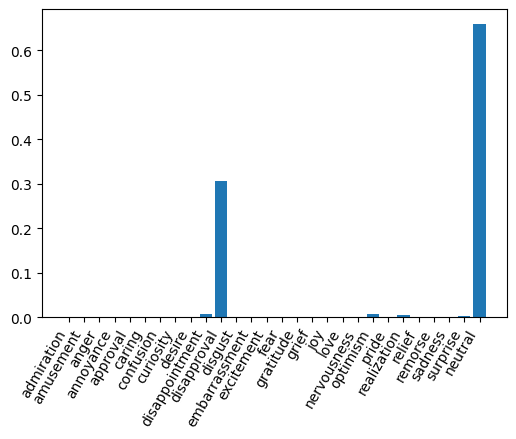

In [199]:
display_sentiment("hold fast to dreams for if dreams die life is a broken-winged bird that cannot fly.")

<ipython-input-198-44e9039f977b>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')


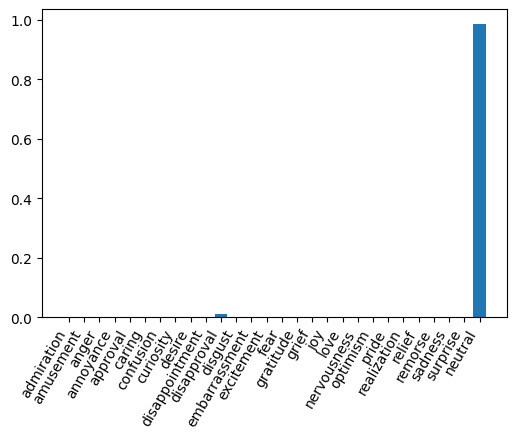

In [200]:
display_sentiment("No mountain, nor sea, no thing of this world could keep us apart, because this is not my world... you are.")

## example sentences (from poems)
- No mountain, nor sea, no thing of this world could keep us apart, because this is not my world... you are.
- hold fast to dreams for if dreams die life is a broken-winged bird that cannot fly.

In [201]:
def display_sentiment(sentence):
    global sentiment, model, device
    res = classify_sentence2(sentence, model, device)
    res = nn.functional.softmax(res, -1).squeeze().tolist()
    res = [int(1000*d)/1000 for d in res]

    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(1, 1, 1)
    ax.bar(sentiment, res)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')
    plt.show()
    plt.close()

<ipython-input-201-ab56bde0cf67>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')


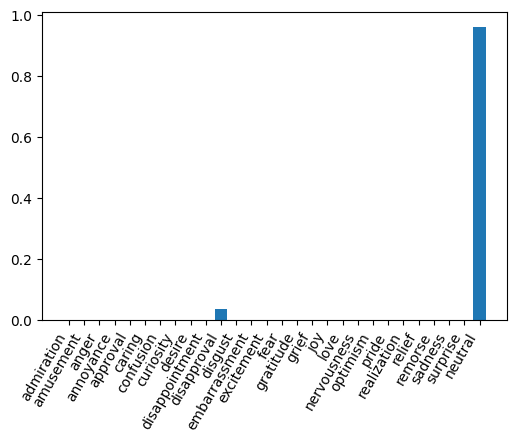

In [202]:
display_sentiment("hold fast to dreams for if dreams die life is a broken-winged bird that cannot fly.")

<ipython-input-201-ab56bde0cf67>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right')


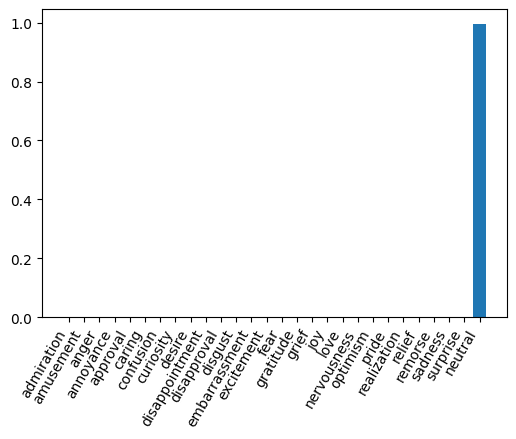

In [203]:
display_sentiment("No mountain, nor sea, no thing of this world could keep us apart, because this is not my world... you are.")